### ID:300595912
### Name:Zihao Zhang

### 1.import

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 2.data loding

In [4]:
data_path = 'traindata'

transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip()
     ])
dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_set, test_set = train_test_split(dataset, train_size=0.8,random_state=309)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32)
classes = ('cherry', 'strawberry', 'tomato')

### Test the transforms

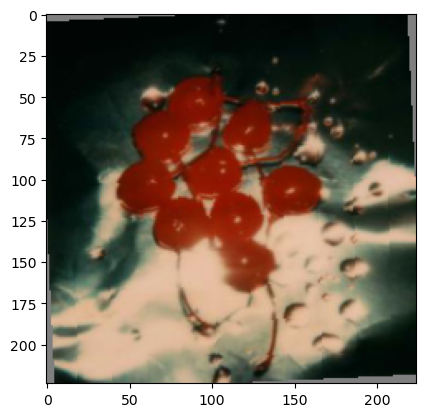

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
img = torchvision.utils.make_grid(images[0])
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()


### MLP

In [6]:
#structure of MLP
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        self.fc1=nn.Linear(3*224*224,512) # hidden layer
        self.act1=nn.ReLU()
        self.fc2 = nn.Linear(512,3)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self,x):
        x = torch.flatten(x,1)#2d-1d
        x=self.fc1(x)
        x=self.act1(x)#activeFuction
        x=self.fc2(x)
        x = self.dropout(x)
        
        return x

In [7]:
#LossFuction & Optim
model = NeuralNet()
LossFuction = nn.CrossEntropyLoss() 
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)#learning rate=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

NeuralNet(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [8]:
train_loss_all,train_accur_all,test_loss_all,test_accur_all = [],[],[],[]# this is for record the loss and accuarcy
for epoch in range(30):  # loop over the dataset multiple times    
    train_num = 0.0
    train_accuracy = 0.0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = LossFuction(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        train_loss += abs(loss.item())*inputs.size(0)
        outputs = torch.argmax(outputs, 1)
        accuracy = torch.sum(outputs == labels)
        train_accuracy = train_accuracy + accuracy
        train_num += inputs.size(0)
    accuracy = train_accuracy/train_num
    loss = train_loss/train_num
    print(f'[{epoch + 1}] loss: {loss}  train_accuracy: {accuracy}')
    train_accur_all.append(accuracy)
    train_loss_all.append(loss)

    # since we're not training, we don't need to calculate the gradients for our outputs
    test_loss = 0
    test_accuracy = 0.0
    test_num = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data# calculate outputs by running images through the network
            outputs = model(images)
            loss = LossFuction(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)# the class with the highest energy is what we choose as prediction
            test_loss = test_loss + abs(loss.item())*images.size(0)
            outputs = torch.argmax(outputs, 1)
            accuracy = torch.sum(outputs == labels)
            test_accuracy = test_accuracy + accuracy
            test_num += images.size(0)
        accuracy_test = test_accuracy/test_num
        loss = test_loss/test_num
        test_loss_all.append(loss)
        test_accur_all.append(accuracy_test)
        print(f'test_accuracy: {accuracy_test}')
print('Finished Training')

[1] loss: 13.62700111959821  train_accuracy: 0.3505442440509796
test_accuracy: 0.3392857015132904
[2] loss: 3.562904407616737  train_accuracy: 0.38403573632240295
test_accuracy: 0.3794642984867096
[3] loss: 2.6301328503749506  train_accuracy: 0.4105498194694519
test_accuracy: 0.4051339328289032
[4] loss: 2.0925392951840234  train_accuracy: 0.47278815507888794
test_accuracy: 0.4095982015132904
[5] loss: 2.0738161767357526  train_accuracy: 0.47976556420326233
test_accuracy: 0.4274553656578064
[6] loss: 2.250671822433195  train_accuracy: 0.4886966347694397
test_accuracy: 0.4386160671710968
[7] loss: 2.1123687658035784  train_accuracy: 0.4828356206417084
test_accuracy: 0.3962053656578064
[8] loss: 1.8483194068527542  train_accuracy: 0.4931621551513672
test_accuracy: 0.421875
[9] loss: 1.702416151420983  train_accuracy: 0.5420039296150208
test_accuracy: 0.4620535671710968
[10] loss: 1.666215821414429  train_accuracy: 0.5461903214454651
test_accuracy: 0.421875
[11] loss: 2.3740954267356504  

In [9]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: cherry is 46.6 %
Accuracy for class: strawberry is 52.5 %
Accuracy for class: tomato is 42.5 %


In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs =  model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 47 %


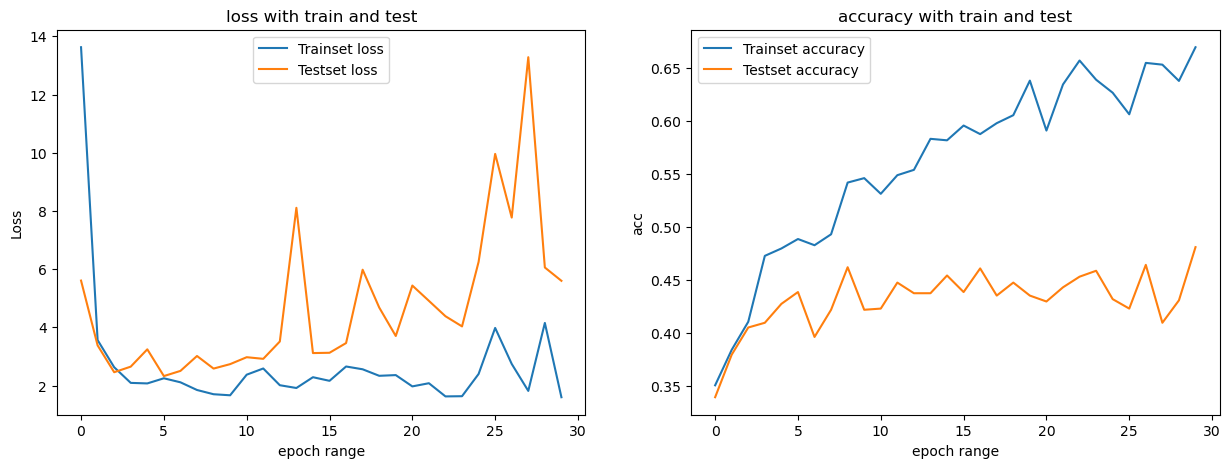

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1 , 2 , 1)
plt.title("loss with train and test")
plt.plot(range(len(train_loss_all)) , train_loss_all,label = "Trainset loss")
plt.plot(range(len(test_loss_all)), test_loss_all,label = "Testset loss")
plt.legend()
plt.xlabel("epoch range")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.title("accuracy with train and test")
plt.plot(range(len(train_accur_all)) , train_accur_all,label = "Trainset accuracy")
plt.plot(range(len(test_accur_all)) , test_accur_all,label = "Testset accuracy")
plt.xlabel("epoch range")
plt.ylabel("acc")
plt.legend()
plt.show()

### CNN

### data loading

In [12]:
# batch size:10(Speed up training)
# Normalize(base on the ImageNet)
train_path = 'traindata'
transform = transforms.Compose(
        [
        transforms.ToTensor(),
        #224*224*3
        transforms.Resize((224,224)),
        transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
        transforms.RandomHorizontalFlip()
         ])
trainset = torchvision.datasets.ImageFolder(train_path, transform=transform)
train_set, test_set = train_test_split(trainset, train_size=0.9,random_state=309)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=10)

In [13]:
#model:vggNet ,good at dealing image problem
#将输入数据通过卷积层和全连接层，最终生成了模型的输出。这个输出通常包括每个类别的分数或概率。
class cnn(nn.Module):
    def __init__(self):
        #16=13convolution layer+3Full connection layer
        super(cnn, self).__init__()
        
        self.Conv1 = nn.Sequential(
            #color image RGB three channel data set, input channel = 3, image size = 224*224
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            #批量归一化是一种用于提高训练稳定性和加速训练的技术。它通常在卷积层中使用。
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 池化层
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Full connection layer
        #全连接层：全连接层用于将卷积层的输出转换为最终的分类结果。
        #全连接层包括几个线性层，它们负责将卷积层的特征映射转化为类别概率。
        self.fc = nn.Sequential(

            nn.Linear(512*7*7, 256, bias=False),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            #Dropout是一种正则化技巧，用于减少过拟合。
            #在全连接层之间添加了Dropout层，它会随机使一些神经元无效，从而帮助模型更好地泛化到新数据。
            # Make half of the neurons ineffective to prevent over fitting caused by excessive parameter quantity
            nn.Dropout(0.5),

            nn.Linear(128, 3, bias=False)
        )
    #这是模型的前向传播方法，它定义了数据如何在模型中流动
    #获得模型输出
    def forward(self, x):
        # Five convolution layers
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x = self.Conv5(x)

        # Data flattening to prepare for the next full connection layer
        x = x.view(-1, 512*7*7)
        x = self.fc(x)
        return x

In [14]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = cnn().to(device)  # Define the network model for training
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(net.parameters(), lr=0.001,momentum=0.9)
print(net)

cnn(
  (Conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
 

In [15]:
train_loss_all,train_accur_all,test_loss_all,test_accur_all = [],[],[],[]# this is for record the loss and accuarcy
for epoch in range(15):  # loop over the dataset multiple times
    train_num = 0.0
    train_accuracy = 0.0
    train_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        train_loss += abs(loss.item()) * inputs.size(0)
        outputs = torch.argmax(outputs, 1)
        accuracy = torch.sum(outputs == labels)
        train_accuracy = train_accuracy + accuracy
        train_num += inputs.size(0)
    accuracy = train_accuracy/train_num
    loss = train_loss/train_num
    print(f'[{epoch + 1}] loss: {loss}  train_accuracy: {accuracy}')
    train_accur_all.append(accuracy)
    train_loss_all.append(loss)

    # since we're not training, we don't need to calculate the gradients for our outputs
    test_loss = 0
    test_accuracy = 0.0
    test_num = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data# calculate outputs by running images through the network
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)# the class with the highest energy is what we choose as prediction
            test_loss = test_loss + abs(loss.item())*images.size(0)
            outputs = torch.argmax(outputs, 1)
            accuracy = torch.sum(outputs == labels)
            test_accuracy = test_accuracy + accuracy
            test_num += images.size(0)
        accuracy_test = test_accuracy/test_num
        loss = test_loss/test_num
        test_loss_all.append(loss)
        test_accur_all.append(accuracy_test)
        print(f'test_accuracy: {accuracy_test}')
print('Finished Training')

[1] loss: 1.04380681103082  train_accuracy: 0.4472835659980774
test_accuracy: 0.4665178656578064
[2] loss: 0.9539408249643297  train_accuracy: 0.5298933386802673
test_accuracy: 0.5290178656578064
[3] loss: 0.8611383648079579  train_accuracy: 0.6234185099601746
test_accuracy: 0.6183035969734192
[4] loss: 0.8057223890384294  train_accuracy: 0.6735301613807678
test_accuracy: 0.7120535969734192
[5] loss: 0.7239133545953741  train_accuracy: 0.726618766784668
test_accuracy: 0.6875000596046448
[6] loss: 0.6876120469065051  train_accuracy: 0.7357975840568542
test_accuracy: 0.7098214626312256
[7] loss: 0.6462433867302523  train_accuracy: 0.7566360831260681
test_accuracy: 0.7008928656578064
[8] loss: 0.6149971552268946  train_accuracy: 0.7730092406272888
test_accuracy: 0.7522321939468384
[9] loss: 0.6114235105267  train_accuracy: 0.7742496132850647
test_accuracy: 0.7410714626312256
[10] loss: 0.586216749076777  train_accuracy: 0.7861573100090027
test_accuracy: 0.738839328289032
[11] loss: 0.5504

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data# calculate outputs by running images through the network
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)# the class with the highest energy is what we choose as prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()     
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 79 %


In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cherry is 62.8 %
Accuracy for class: strawberry is 86.1 %
Accuracy for class: tomato is 90.3 %


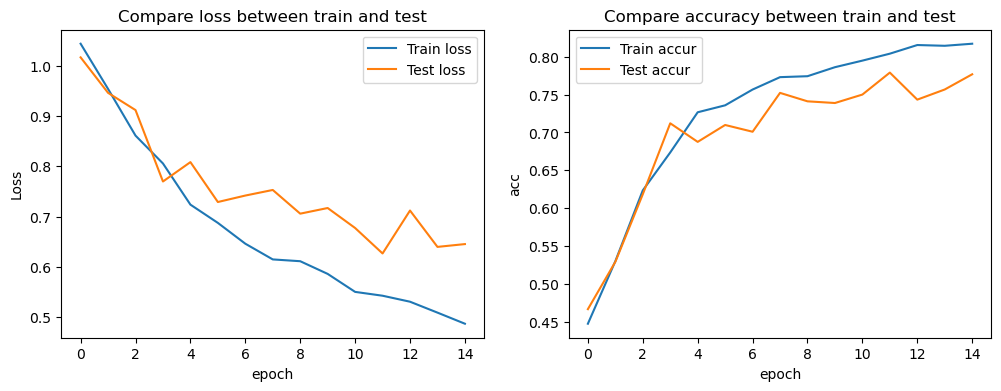

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1 , 2 , 1)
plt.title("Compare loss between train and test")
plt.plot(range(len(train_loss_all)) , train_loss_all,label = "Train loss")
plt.plot(range(len(test_loss_all)), test_loss_all,label = "Test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.title("Compare accuracy between train and test")
train,test = [],[]
for val in train_accur_all:
    train.append(val.cpu().numpy())
for val in test_accur_all:
    test.append(val.cpu().numpy())
plt.plot(range(len(train)) , train,label = "Train accur")
plt.plot(range(len(test)) , test,label = "Test accur")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [21]:
PATH = './cnn_model.pth'
torch.save(net.state_dict(), PATH)